Shape: (55808, 13)
is_promoted
0    0.907146
1    0.092854
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55808 entries, 0 to 55807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           55808 non-null  int64  
 1   department            55808 non-null  object 
 2   region                55808 non-null  object 
 3   education             53399 non-null  object 
 4   gender                55808 non-null  object 
 5   recruitment_channel   55808 non-null  object 
 6   no_of_trainings       55808 non-null  int64  
 7   age                   55808 non-null  int64  
 8   previous_year_rating  51684 non-null  float64
 9   length_of_service     55808 non-null  int64  
 10  awards_won            55808 non-null  int64  
 11  avg_training_score    53248 non-null  float64
 12  is_promoted           55808 non-null  int64  
dtypes: float64(2), int64(6), obje

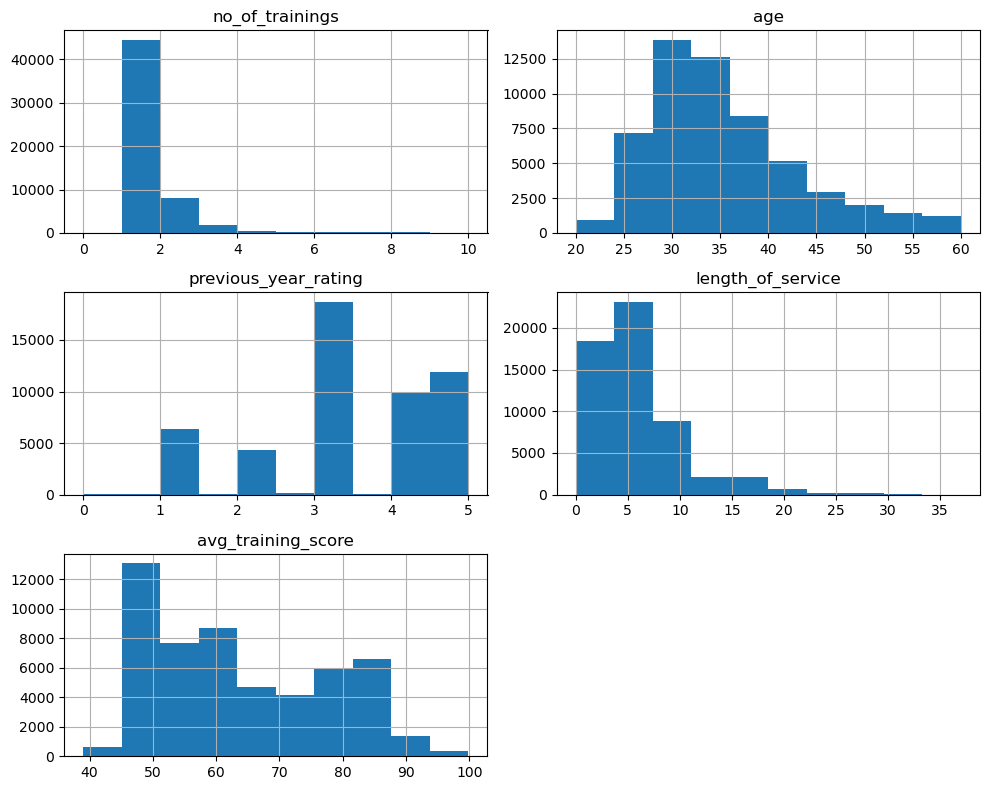

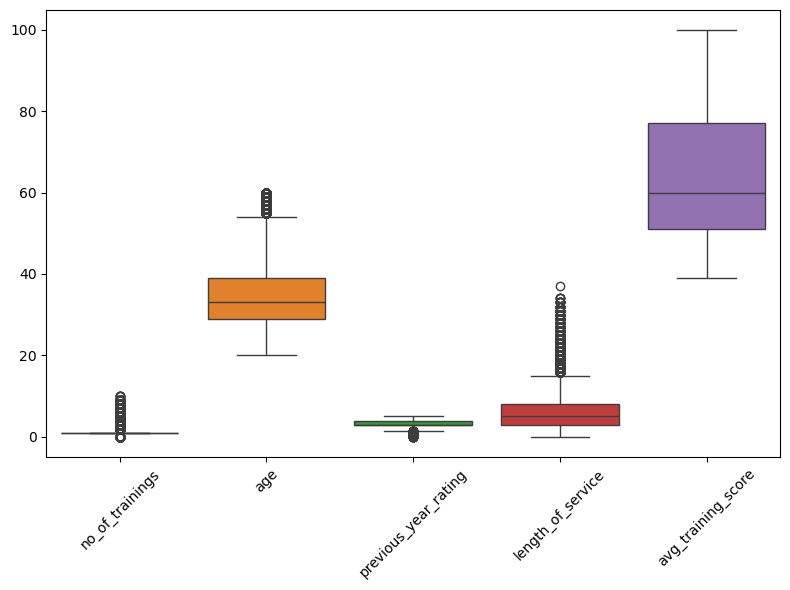

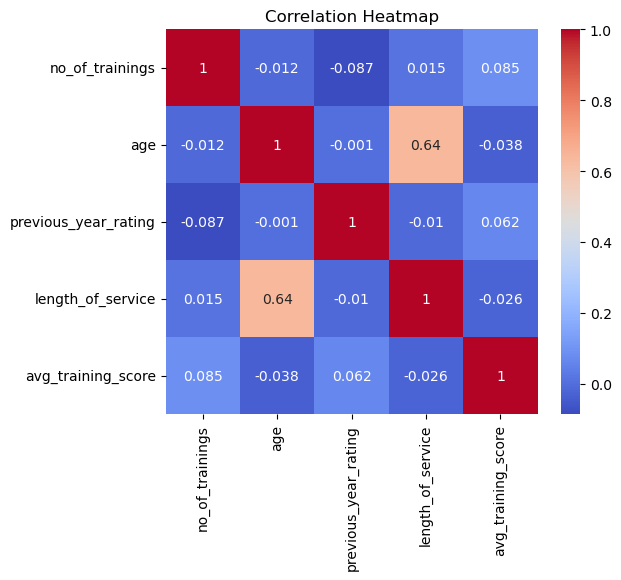

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset (train.csv from Kaggle) into DataFrame `df`
df = pd.read_csv("employee_promotion_updated.csv")

# Basic info
print("Shape:", df.shape)
print(df["is_promoted"].value_counts(normalize=True))
print(df.info())
print(df.describe(include="all"))

# Histograms of numeric features
numeric_cols = [
    "no_of_trainings",
    "age",
    "previous_year_rating",
    "length_of_service",
    "avg_training_score",
]
df[numeric_cols].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

# Boxplot of numeric features
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap of numeric features
plt.figure(figsize=(6, 5))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Drop unique ID
df = df.drop(columns=["employee_id"])

# Impute missing values
df["education"] = df["education"].fillna(df["education"].mode()[0])
df["previous_year_rating"] = df["previous_year_rating"].fillna(0)
df["avg_training_score"] = df["avg_training_score"].fillna(df["avg_training_score"].mean())

# Encode categorical variables
categorical_cols = [
    "department",
    "region",
    "education",
    "gender",
    "recruitment_channel",
]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Scale numeric features
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["is_promoted"])
y = df["is_promoted"]

# 60% train, 20% val, 20% test with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test shapes: (33484, 11) (11162, 11) (11162, 11)


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import time

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "k-NN": KNeighborsClassifier(),
    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(50,), max_iter=200, random_state=42
    ),
}

# Train models and measure time
trained_models = {}
timings = {}
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start
    trained_models[name] = model
    timings[name] = elapsed
    print(f"{name} training time: {elapsed:.3f} s")

Decision Tree training time: 0.122 s
k-NN training time: 0.051 s
Neural Network training time: 5.720 s


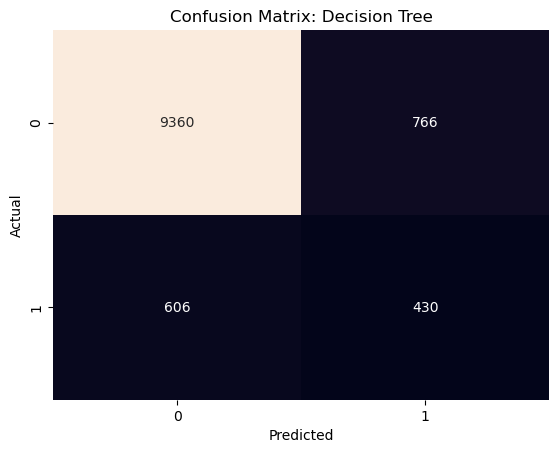

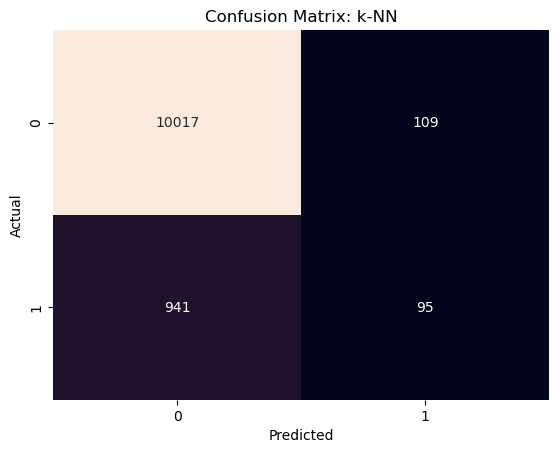

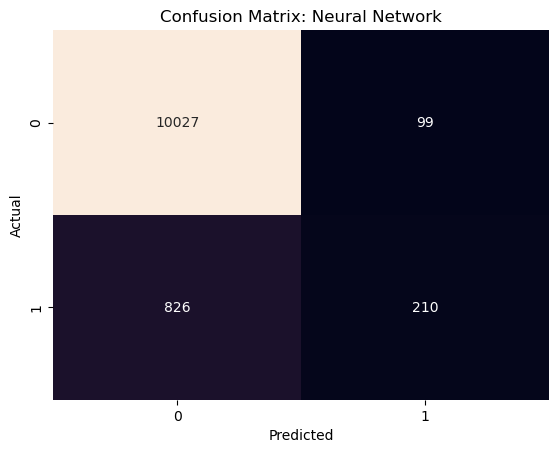

            Model  Accuracy  Precision    Recall        F1  Train Time
0   Decision Tree  0.877083   0.359532  0.415058  0.385305    0.122329
1            k-NN  0.905931   0.465686  0.091699  0.153226    0.051021
2  Neural Network  0.917130   0.679612  0.202703  0.312268    5.720277


In [5]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

results = []
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results.append((name, acc, prec, rec, f1, timings[name]))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Confusion Matrix: {name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

# Display metrics in a table
import pandas as pd

metrics_df = pd.DataFrame(
    results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "Train Time"]
)
print(metrics_df)

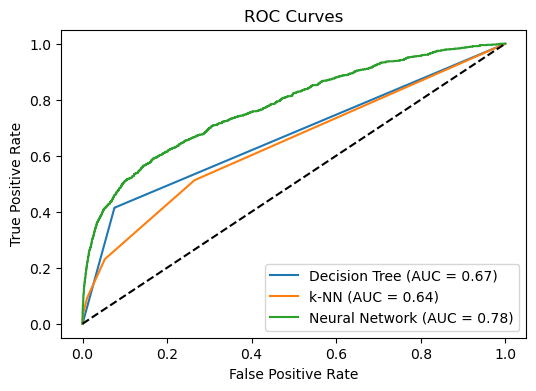

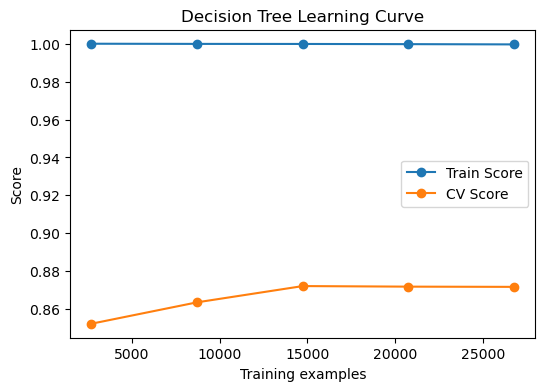

In [6]:
from sklearn.metrics import roc_curve, auc

# Plot ROC curves
plt.figure(figsize=(6, 4))
for name, model in trained_models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Learning curve for Decision Tree
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    DecisionTreeClassifier(random_state=42),
    X_train,
    y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
)
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="Train Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), "o-", label="CV Score")
plt.title("Decision Tree Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend()
plt.show()